In [1]:
import matplotlib.pyplot as     plt
import numpy             as     np
import pandas            as     pd
import calendar
import yaml
import sys
import os
import netCDF4
import glob
import xarray as xr
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature


sys.path.append('/home/veilleux/Projet/Projet_SACHR/analyses_and_figures')
from aux_CALIPSO         import extract_domain_coord
from aux_CALIPSO         import extract_satellite_track
from aux_grid_projection import convert_latlon_to_domain_indices
#from auxilliary_functions import get_args


sys.path.append('/home/veilleux/Projet/Projet_SACHR/analyses_and_figures/python_modules')
from domain    import generate_domain_coord
from domain    import convert_latlon_to_domain_indices


import warnings
warnings.filterwarnings("ignore")



# FUNCTIONS

In [2]:
def format_levels(datain, overlap_coeff, Nlevout):
    Nray      = datain.shape[0]
    Nlevin    = datain.shape[1]
    Nray_coef = len(overlap_coeff)     # Nray_coeff = 1 pour CALIPSO et COSP, car le profil vertical (et donc les coefficients)  ne change pas
    dataout   = np.zeros([Nray,Nlevout])
    for n in range(Nray):
        for levout in range(Nlevout-1): 
            #print(levout)
    
            d = 0
            if    Nray_coef == 1: olc = overlap_coeff[0][levout]
            else                : olc = overlap_coeff[n][levout]
            for levin in olc:
                if format_level_method == 'maximum_overlap':
                    if  datain[n,Nlevin-levin-1]>d:                             
                        dataout[n,Nlevout-1-levout] = datain[n,Nlevin-levin-1]
                elif format_level_method == 'minimum_overlap':
                    print('minimum_overlap method is not implemented')
                    exit()
                elif format_level_method == 'random_maximum_overlap':
                    print('random_maximum_overlap method is not implemented')
                    exit()
                elif format_level_method == 'weighted_mean':
                    dataout[n,Nlevout-1-levout] +=  olc[levin] * datain[n,Nlevin-levin-1] 
                    #print(dataout)
                #if datain[n,levin] > 0 and n == 0:
                #    print('n=%3d levout=%3d (levin=%3d): %7.3f * %7.3f = %7.3f, tot=%7.3f' % (n, levout, levin, olc[levin], datain[n,levin] , olc[levin] * datain[n,levin] , dataout[n,levout]))    
    return dataout

def convert_calipso_data_in_2D(ncfile, varname, domain, coord_domain, dim):
    ''' Extract the part of the track that is INSIDE the domain '''
    ''' More than 1 "ray" may be located inside a "pixel", this is why we are computing a mean '''
    track = extract_satellite_track(ncfile, coord_domain, showtrack=False)
    indices = convert_latlon_to_domain_indices(track, domain)
    ds      = netCDF4.Dataset(ncfile,'r')
    data    = ds[varname][track['index']]
    dim       = [data.shape[1], dim[1], dim[2]]  # set number of vertical level. dim(data) = nray x nlvel
    data_sum  = np.ones(dim) * 0
    data_n    = np.ones(dim) * 0
    Nray = len(indices['i'])
    for n in range(Nray):
        I = indices['i'][n]
        J = indices['j'][n]
        data_sum[:, I, J] = data_sum[:, I, J] + data[n]
        data_n  [:, I, J] = data_n  [:, I, J] + 1
    return data_sum/data_n

def getOverlap(a, b):
    min_a = min(a[0], a[1])
    max_a = max(a[0], a[1])
    min_b = min(b[0], b[1])
    max_b = max(b[0], b[1])
    return max(0, min(max_a, max_b) - max(min_a, min_b))

def compute_overlap_coeff(src_layer, target_layer):    
    if len(src_layer.shape) == 1: 
        src_layer = src_layer[:,np.newaxis]

    nlev_src      = src_layer.shape[0]
    Nray          = src_layer.shape[1]
    nlev_target   = target_layer.shape[0]
    overlap_coeff = {}
    #print('Nray',Nray)
    #print('nlev_target',nlev_target)
    for n in range(Nray):
        overlap_coeff[n] = {}
        #print(overlap_coeff)
        for lev1 in range(nlev_target-1):
            #print('lev1',lev1)
            overlap_coeff[n][lev1] = {}
            range1 = [target_layer[lev1], target_layer[lev1+1] ]
            total_overlap = 0
            for lev2 in range(nlev_src-1):
                range2        = [src_layer[lev2,n], src_layer[lev2+1,n]]
                #print('Range1 :',range1, 'Range2 :',range2)
                overlap       = getOverlap(range1, range2)
                if overlap > 0:
                    overlap_coeff[n][lev1][lev2] = overlap
                total_overlap = total_overlap + overlap
                #print(n, end='');
                #print('  %4d: [%6.2f,%6.2f]' % (lev1, range1[0], range1[1]), end='')
                #print('  %4d: [%6.2f,%6.2f]' % (lev2, range2[0], range2[1]), end='')
                #print('  %f %f' % (overlap, total_overlap))                        
            for lev2 in overlap_coeff[n][lev1]:
                overlap_coeff[n][lev1][lev2] = overlap_coeff[n][lev1][lev2] / total_overlap
        #print(overlap_coeff)
    return overlap_coeff

def create_output(column_formatted_sum, column_formatted_n, layerout, dirout, bukovsky_region, YYYYMM):
    fileout = "%s/%s_%s/%s/txt/%s.txt" % (dirout, layerout_dataset, format_level_method, bukovsky_region, YYYYMM)
    print(fileout)
    if not os.path.exists(os.path.dirname(fileout)): os.makedirs(os.path.dirname(fileout))
    f = open(fileout, 'w')

    # Header
    print('altitude\t', end='', file=f)
    for dataset in column_formatted_sum:
        print('%s_sum\t%s_n\t' % (dataset,dataset), end='', file=f)
    print('', file=f)
    
    
    # Data
    for n,layer in enumerate(np.flipud(layerout)):
        print('%f\t' % layer, end='',file=f)
        for dataset in column_formatted_sum:
            print('%f\t%f\t' % (column_formatted_sum[dataset][n], column_formatted_n[dataset][n]), end='', file=f)

        print('', file=f)
        n += 1
    f.close()
    print(fileout)
 

In [3]:
def make_map(ncfile, data,cmap='jet',vext=[0,1],showcolorbar=True):
    dpi = 150

    # Get lat, lon and cartopy_projection_object
    ds  = xr.open_dataset(ncfile)
    lat = ds.lat.values
    lon = ds.lon.values
    m   = ccrs.RotatedPole(ds.rotated_pole.grid_north_pole_longitude,
                           ds.rotated_pole.grid_north_pole_latitude)

    # Domain limites
    xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())

    # Creating figure
    fig = plt.figure()
    fig.set_dpi(dpi)
    ax = plt.axes(projection=m)
    pc = ax.pcolormesh(lon, lat, data, cmap=cmap,vmin=vext[0], vmax=vext[1], transform=ccrs.PlateCarree())
    vext[0], vext[1] = pc.get_clim() # Useful when input was vext[0]=None and/or vext[1]=None

    # Domain limites
    xll, yll = m.transform_point(lon[ 0,  0],lat[ 0,  0], ccrs.PlateCarree())
    xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
    ax.set_extent([xll, xur, yll, yur], crs=m)

    # Coastlines + political borders
    ax.coastlines()
    L0_country_ALL = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes',scale='50m',facecolor='none')
    ax.add_feature(L0_country_ALL, edgecolor='black')

    # Colorbar
    if showcolorbar == True:

        if   vext[0] ==  -vext[1]: extend = 'both'
        else                     : extend = 'neither'
        sm = plt.cm.ScalarMappable(cmap=cmap,norm=plt.Normalize(vext[0],vext[1]))
        sm._A = []
        plt.colorbar(sm,ax=ax, extend=extend)

    plt.show()

# MAIN

In [10]:
# Hardcoded
format_level_method = 'weighted_mean'
bukovsky_regions = ['ColdNEPacific', 'WarmNEPacific', 'Southwest', 'NPlains', 'GreatLakes','WarmNWAtlantic','EastBoreal', 'Hudson', 'PacificNW', 'Appalachia']
datasets = [ 'COSPIN', 'COSPOUT', 'CALIPSO']
layerout_dataset = 'COSPOUT'
domain = 'NAM11'

working_directory = '/home/veilleux/Projet/Projet_SACHR/analyses_and_figures'
yml_file = working_directory + '/' + 'config.yml'
stream = open(yml_file,'r')
config = yaml.safe_load(stream)
domain       = config['domain'  ]
bukovsky     = config['bukovsky']['chinook']
CALIPSO_list = config['CALIPSO' ]['list'  ]
COSP2_input  = config['COSP2'   ]['input' ]
COSP2_output = config['COSP2'   ]['output']
GEM5_NetCDF  = config['GEM5'    ]['NetCDF']
dirout       = config['CALIPSOvsCOSP2vsGEM5_maps']['Profiles']
print(dirout)

year = 2014
month = 4
# Selecting files for the desired year/month from the file list (--> CALIPSO is passing over the domain)
last_day_of_the_month = calendar.monthrange(year, month)[1]
YYYYMMDDi = int('%4d%02d%02d' % (year,month,1))
YYYYMMDDf = int('%4d%02d%02d' % (year,month,last_day_of_the_month))
list_txt  = CALIPSO_list + '/' + domain + '/' + str(year) + '.txt'
list_df   = pd.read_csv(list_txt,delimiter='\s+', header=None)


list_df.columns      = ['nc_CALIPSO', 'ndata', 'ti', 'tf', 'date', 'MM', 'date_gem', 't_gem']
list_df['YYYYMMDD']  = [int(x[0:8]) for x in list_df['date'].astype(str)]
list_df              = list_df[   list_df['YYYYMMDD'] >= YYYYMMDDi].reset_index(drop=True)
list_df              = list_df[   list_df['YYYYMMDD'] <= YYYYMMDDf].reset_index(drop=True)
#list_df              = list_df.loc[list_df['nc_CALIPSO'].str.contains('D.nc')].reset_index(drop=True)

test_COSPIN = COSP2_input + "/201401/"+'201401130900.nc'
test_COSPOUT = COSP2_output + '/NAM11/M01SC002/CALIPSO/calipso_cloudprofile/201401/' +'cospout_201401130600_2D.nc'

test_CALIPSO = '/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-01-01T11-24-33ZN.nc'
ds_CAL       = xr.open_dataset(test_CALIPSO) 
pressure = ds_CAL['Pressure'].values
T = ds_CAL['Temperature'].values
#print(pressure[10,:])
#print(T[10,:])

ds_COSPIN               = xr.open_dataset(test_COSPIN)
data        = np.flipud(ds_COSPIN['tca'   ].values )
layers_COSPIN_2DxNlevin = ds_COSPIN['height'].values

ds_COSPOUT        = xr.open_dataset(test_COSPOUT)
layers_COSPOUT = np.flipud(ds_COSPOUT['levStat'].values/1000) - ds_COSPOUT['levStat'].values[-1]/1000    

layers_CALIPSO_below_20km = np.arange(-0.5,-0.5+345*0.06,0.06)
layers_CALIPSO_above_20km = np.arange(20.2,20.2+54*0.18,0.18)

layers_CALIPSO_modified= np.concatenate((layers_CALIPSO_below_20km, layers_CALIPSO_above_20km))

layers_CALIPSO = np.arange(-0.5,-0.5+399*0.06,0.06)
print('############## COSPOUT LAYEROUT ###############')
print(layers_COSPOUT)
print('##############      COSPIN      ###############')
input(' ')
#print(layers_COSPIN_2DxNlevin[:,0,0])
print(ds_COSPIN['pfull'].values)
print('##############     CALIPSO      ###############')
np.set_printoptions(suppress=True) #prevent numpy exponential 

print(layers_CALIPSO[0:320])
print(layers_CALIPSO_modified[0:320])


#print(layers_COSPOUT)

/chinook/veilleux/DATA/CALIPSOvsGEM5vsCOSP
############## COSPOUT LAYEROUT ###############
[ 0.          0.48000002  0.96000004  1.4399999   1.9200001   2.4
  2.8799999   3.36        3.84        4.32        4.8         5.28
  5.76        6.2400002   6.7200003   7.2000003   7.6800003   8.16
  8.64        9.12        9.6        10.08       10.56       11.04
 11.52       12.         12.4800005  12.96       13.440001   13.92
 14.400001   14.88       15.360001   15.84       16.32       16.800001
 17.28       17.76       18.24       18.72      ]
##############      COSPIN      ###############


KeyboardInterrupt: Interrupted by user

ColdNEPacific 201404011100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-01T10-31-37ZN.nc

ColdNEPacific 201404011200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-01T11-18-07ZD.nc

ColdNEPacific 201404011200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-01T12-10-32ZN.nc

ColdNEPacific 201404011400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-01T12-57-02ZD.nc

ColdNEPacific 201404011400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-01T13-49-28ZN.nc

ColdNEPacific 201404011500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-01T14-35-53ZD.nc

ColdNEPacific 201404011700
/pampa/poitra

ColdNEPacific 201404050000
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-04T23-21-43ZD.nc

ColdNEPacific 201404050400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-05T03-31-54ZN.nc

ColdNEPacific 201404050500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-05T04-18-24ZD.nc

ColdNEPacific 201404050500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-05T05-10-49ZN.nc

ColdNEPacific 201404050700
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-05T05-57-14ZD.nc

ColdNEPacific 201404050700
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-05T06-49-44ZN.nc

ColdNEPacific 201404050800
/pampa/poitra

ColdNEPacific 201404071300
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-07T12-20-46ZD.nc

ColdNEPacific 201404071300
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-07T13-13-12ZN.nc

ColdNEPacific 201404071500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-07T13-59-37ZD.nc

ColdNEPacific 201404071500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-07T14-52-07ZN.nc

ColdNEPacific 201404071600
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-07T15-38-32ZD.nc

ColdNEPacific 201404071800
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-07T17-17-27ZD.nc

ColdNEPacific 201404072000
/pampa/poitra

/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-10T07-08-55ZN.nc

ColdNEPacific 201404100900
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-10T07-55-20ZD.nc

ColdNEPacific 201404100900
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-10T08-47-46ZN.nc

ColdNEPacific 201404101000
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-10T09-34-11ZD.nc

ColdNEPacific 201404101100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-10T10-26-41ZN.nc

ColdNEPacific 201404101200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-10T11-13-06ZD.nc

ColdNEPacific 201404101200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_0

/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-12T17-36-33ZD.nc

ColdNEPacific 201404122000
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-12T19-15-28ZD.nc

ColdNEPacific 201404122100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-12T20-54-18ZD.nc

ColdNEPacific 201404122300
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-12T22-33-14ZD.nc

ColdNEPacific 201404130100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-13T00-12-09ZD.nc

ColdNEPacific 201404130400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-13T03-29-54ZD.nc

ColdNEPacific 201404130400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_0

/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-15T08-14-26ZD.nc

ColdNEPacific 201404150900
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-15T09-06-51ZN.nc

ColdNEPacific 201404151100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-15T09-53-17ZD.nc

ColdNEPacific 201404151100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-15T10-45-42ZN.nc

ColdNEPacific 201404151200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-15T11-32-12ZD.nc

ColdNEPacific 201404151200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-15T12-24-37ZN.nc

ColdNEPacific 201404151400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_0

/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-17T19-34-29ZD.nc

ColdNEPacific 201404172200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-17T21-13-19ZD.nc

ColdNEPacific 201404180000
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-17T22-52-15ZD.nc

ColdNEPacific 201404180300
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-18T03-02-25ZN.nc

ColdNEPacific 201404180500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-18T03-48-55ZD.nc

ColdNEPacific 201404180500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-18T04-41-20ZN.nc

ColdNEPacific 201404180600
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_0

/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-23T22-15-36ZD.nc

ColdNEPacific 201404241100
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-24T10-40-13ZN.nc

ColdNEPacific 201404241200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-24T11-26-43ZD.nc

ColdNEPacific 201404241200
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-24T12-19-08ZN.nc

ColdNEPacific 201404241400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-24T13-05-38ZD.nc

ColdNEPacific 201404241400
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_05kmCPro-Standard-V4/NetCDF/2014/CAL_LID_L2_05kmCPro-Standard-V4-20.2014-04-24T13-57-58ZN.nc

ColdNEPacific 201404241500
/pampa/poitras/DATA/CALIPSO/CAL_LID_L2_0

KeyboardInterrupt: 

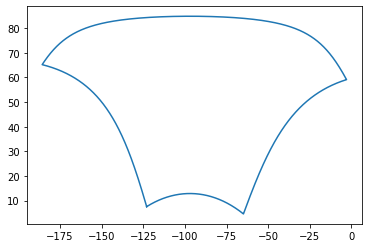

In [7]:
for bukovsky_region in bukovsky_regions:

    # bukovsky mask
    file_bukovsky = bukovsky + '/final/' + bukovsky_region + '.nc'
    mask_bukovsky = np.squeeze(xr.open_dataset(file_bukovsky)['mask'].values)

    column_sum = {}
    column_n   = {}
    column_formatted_sum = {}
    column_formatted_n   = {}

    data   = {}
    layers = {}

    # loop on each timestep
    for index, row in list_df.iterrows():

        YYYYMMDDhhmm = str(row['date'])
        YYYYMM       = str(row['date'])[0:6]
        YYYYMMDD_gem = str(row['date_gem'])
        YYYYMM_gem   = str(row['date_gem'])[0:6]

        ######################################
        # Get data + layers for each dataset #
        ######################################
        ncfile_COSPOUT = '%s/%s/M01SC002/CALIPSO/calipso_cloudprofile/%s/cospout_%s_2D.nc' % (COSP2_output, domain, YYYYMM, YYYYMMDDhhmm) 
        ncfile_CALIPSO = row['nc_CALIPSO']
        ncfile_GEM5    = glob.glob('%s/*%s/pm*%sd.nc' % (GEM5_NetCDF, YYYYMM_gem, YYYYMMDD_gem))[0]
        ncfile_COSPIN  = '%s/%s/%s.nc' % (COSP2_input, YYYYMM, YYYYMMDDhhmm)
        
        if  os.path.exists(ncfile_COSPOUT) and os.path.exists(ncfile_CALIPSO) and os.path.exists(ncfile_GEM5) and os.path.exists(ncfile_COSPIN):
            print(bukovsky_region, YYYYMMDDhhmm) 
            ### COSP2 output ###
            file_COSPOUT      = '%s/%s/M01SC002/CALIPSO/calipso_cloudprofile/%s/cospout_%s_2D.nc' % (COSP2_output, domain, YYYYMM, YYYYMMDDhhmm)
            ds_COSPOUT        = xr.open_dataset(file_COSPOUT)
            data_COSPOUT      = ds_COSPOUT['clcalipso'].values.transpose(0, 2, 1) / 100         # range [0,100] --> [0,1]
            data  ['COSPOUT'] = np.where(data_COSPOUT<0, 0, data_COSPOUT) 
            layers['COSPOUT'] = np.flipud(ds_COSPOUT['levStat'].values/1000) - ds_COSPOUT['levStat'].values[-1]/1000    

            ### COSP2 input ###
            file_COSPIN             = '%s/%s/%s.nc' % (COSP2_input, YYYYMM, YYYYMMDDhhmm)
            ds_COSPIN               = xr.open_dataset(file_COSPIN)
            data  ['COSPIN']        = np.flipud(ds_COSPIN['tca'   ].values )
            layers_COSPIN_2DxNlevin = ds_COSPIN['height'].values / 1000

             ### GEM5 ### 
             #  On utilise COSPIN au lieu de GEM5 car les hauteurs ont déjà été calculé  dans COSPIN 
             #  Les fichiers de GEM 5 on des pas de temps, alors que pour COSPIN il y a un seul pas de temps
             #  la fonction extract_coord_dom utilisé plus bas, s'attends à avoir des pas de temps, c,esy pourquoi on utilise file_GEM5
             #  Il faudrait modifier la fonction extract_coord_dom pour pouvoir utilisé file_COSPIN ...
             #  Autrement la couverture nuageuse est la même

            file_GEM5    = glob.glob('%s/*%s/pm*%sd.nc' % (GEM5_NetCDF, YYYYMM_gem, YYYYMMDD_gem))[0]
            ds_GEM5      = xr.open_dataset(file_GEM5).isel(time=row['t_gem'])
            data['GEM5'] = ds_GEM5 ['FN'].values

            ### CALISPO ###
            file_CALISPO = row['nc_CALIPSO']
            if index == 0:  
                coord_domain = extract_domain_coord(file_GEM5)
                dim          = data['COSPIN'].shape
            data_CALIPSO = convert_calipso_data_in_2D(row['nc_CALIPSO'], 'Cloud_Layer_Fraction', domain, coord_domain, dim) 
            data  ['CALIPSO'] = data_CALIPSO / 30 # range: [0,30] --> [0,1]
            layers['CALIPSO'] = np.arange(-0.5,-0.5+399*0.06,0.06)
            # https://asdc.larc.nasa.gov/documents/calipso/quality_summaries/CALIOP_L2ProfileProducts_2.01.pdf
            #          The cloud profile products are reported at a uniform spatial resolution of 60-m vertically and 
            #          5-km horizontally, over a nominal altitude range from 20-km to -0.5-km
            print(file_CALISPO)
            print('')

            layerout = layers[layerout_dataset]
            Nlevout  = len(layerout)
            overlap_coeff = {}
            for dataset in datasets:

                if dataset in layers:
                    overlap_coeff[dataset] = compute_overlap_coeff(layers[dataset], layerout)
            #print(overlap_coeff)  
            #####################
            # Mask              #
            #####################
            mask_track = np.where(np.isnan(data_CALIPSO).any(axis=0) == 0, 1 , np.nan)
            mask       = mask_track * mask_bukovsky

            #make_map(file_bukovsky, mask,'jet',vext=[0,1],showcolorbar=True)

            ###########################################
            ####    Original profil ----> Formated  ###
            ###########################################
            profils_original  = {}
            profils_formatted = {}
            indices = np.where(mask == 1)
            N = len(indices[0]) 

            for dataset in datasets:
                Nlevin = data[dataset].shape[0]
                profils_original[dataset] = np.zeros([N, Nlevin]) * np.nan
                if index == 0:
                    column_formatted_sum [dataset] = np.zeros(Nlevout)
                    column_formatted_n   [dataset] = np.zeros(Nlevout)

                    if dataset == 'CALIPSO':
                        column_formatted_sum[dataset] = np.zeros(Nlevout)
                        column_formatted_n  [dataset] = np.zeros(Nlevout)

                ### Extracting data to create profil: (2D x Nlevin --> N x Nlevin)
                for n in range(N):
                    i = indices[0][n]
                    j = indices[1][n]
                    profils_original[dataset][n,:] = data[dataset][:,i,j]

                ### Extracting layer height for COSPIN: (2D x Nlevin --> Nlevin X N)  oui on besoin de Nlevion x N à l'envers, il faudrait modifier le code pour tout uniformisier
                if dataset == 'COSPIN':
                    layers[dataset] = np.zeros([Nlevin,N])
                    for n in range(N):
                        i = indices[0][n]
                        j = indices[1][n]
                        layers[dataset][:,n] = layers_COSPIN_2DxNlevin[:,i,j]
                    overlap_coeff[dataset] = compute_overlap_coeff(layers[dataset], layerout)
                    #print(overlap_coeff)
                ### Formatting vertical levels: (N x Nlevin --> N x Nlevout)
                if   dataset == layerout_dataset: profils_formatted[dataset] = profils_original[dataset]
                else                            : profils_formatted[dataset] = format_levels(profils_original[dataset], overlap_coeff[dataset], Nlevout)


                ### Aggregating the N individual profils into a single column (N x Nlevout --> 1 x Nlevout)
                column_formatted_sum[dataset] +=  np.nansum( profils_formatted[dataset]                         , axis=0)
                column_formatted_n  [dataset] +=  np.sum   ( np.where(np.isnan(profils_formatted[dataset]) ,0,1), axis=0)

        #create_output(column_formatted_sum, column_formatted_n, layerout, dirout,  bukovsky_region, YYYYMM)



In [ ]:




[Errno 2] No such file or directory: b'/pampa/poitras/DATA/COSP2/COSPOUT/COSP2_NAM-11m_ERA5_GEM5_CLASS_NEWVEG_newP3-SCPF_SN_Lakes/NAM11/M01SC002/CALIPSO/calipso_cloudprofile/201404/cospout_201404091500_2D.nc'
